#Mounting Google  drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data pre-processing

##Getting the data from drive and unziping it

In [ ]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import zipfile as zf
import random

In [ ]:
drive_dataset_path = '/content/drive/MyDrive/Colab Notebooks/dataset/NSFWData.zip'
dataset_path = '/content/dataset'

In [ ]:
os.mkdir('/content/dataset')

FileExistsError: ignored

**Unzipping the dataset**

In [ ]:
with zf.ZipFile(drive_dataset_path) as zip_ref:
  zip_ref.extractall('/content/dataset/')

In [ ]:
os.listdir(dataset_path)

['drugs', 'natural', 'violence']

***These are the number of imgs i have for every class***
- Note that most of the images in violence and drugs classes are augmented 

In [ ]:
!ls /content/dataset/drugs/ | wc -l
!ls /content/dataset/violence/ | wc -l
!ls /content/dataset/natural/ | wc -l

3441
3024
3776


### Putting the data into a big list
1. Every image will be a numpy list with size of (224, 224, 3)
1. Besides the image will be an Integer that represents the class label
1. Shuffle the data
1. spliting them into imgs and labels
1. spliting them into train and test set
1. The final shape will be (n_imgs, 224, 224, 3)

In [ ]:
data_set = []
img_sze = (224, 224)
cls_names = {'drugs': 0, 'violence': 1, 'natural': 2}

for dir_name in os.listdir(dataset_path):
  dir_path = os.path.join(dataset_path, dir_name)
  label = int(cls_names[dir_name])
  print(f'{dir_name} with label {label} and type {type(label)}')
  count = 0
  for img_name in os.listdir(dir_path):
    count += 1
    img_path = os.path.join(dir_path, img_name)

    #loading and resizing and converting the image
    img = Image.open(img_path).convert('RGB')
    img = img.resize(img_sze)
    arr_img = np.array(img)

    #Adding the label to the image
    arr_img_dim = np.array([arr_img, label])
    # append the image to the data_set
    data_set.append(arr_img_dim)
  print(count)

drugs with label 0 and type <class 'int'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


3441
natural with label 2 and type <class 'int'>
3776
violence with label 1 and type <class 'int'>
3024


In [ ]:
data_set = np.array(data_set)

In [ ]:
print(data_set.shape)
print(data_set[0][0].shape)

(10241, 2)
(224, 224, 3)


###Splitting the data into imgs and labels

In [ ]:
imgs = [example[0] for example in data_set]
labels = [example[1] for example in data_set]

In [ ]:
print(f'The shape of single image {imgs[0].shape}')
print(f'The shape of single label {type(labels[0])}')
print(f'We have a {len(imgs)} number of images and {len(labels)} as their labels')

The shape of single image (224, 224, 3)
The shape of single label <class 'int'>
We have a 10241 number of images and 10241 as their labels


In [ ]:
count = 0
for i in range(len(labels)):
  if labels[i] != 0:
    count += 1
print(count)

6800


This image has a label to 0


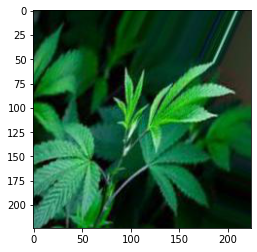

In [ ]:
sample = Image.fromarray(imgs[25], 'RGB')
plt.imshow(sample)
sample_label = labels[25]
print(f'This image has a label to {sample_label}')

In [ ]:
imgs = np.array(imgs)
labels = np.array(labels)

***Realising memory***

In [ ]:
del data_set

***Normalizing our images***

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.2, shuffle=True)

### Saving the dataset

In [ ]:
!mkdir /content/preprocessedDataset

In [ ]:
np.save('/content/preprocessedDataset/X_train', X_train)
np.save('/content/preprocessedDataset/X_test', X_test)
np.save('/content/preprocessedDataset/y_train', y_train)
np.save('/content/preprocessedDataset/y_test', y_test)

In [ ]:
!cp /content/preprocessedDataset/* /content/drive/MyDrive/Colab\ Notebooks/dataset/.

#Creating the model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet import preprocess_input

In [ ]:
mobile = tf.keras.applications.MobileNet()

In [ ]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

**taking all the model layers EXCLUDING THE LAST 1 LAYER**

In [ ]:
base_in = mobile.layers[-1].output
base_out = Dense(units=3, activation='softmax')(base_in)

**Merging layers with the created dense layer**

In [ ]:
model = Model(inputs=mobile.input, outputs=base_out)

**Freezing all the layers except the last 18 layer that I'm gonna hyper tune**

In [ ]:
for layer in model.layers[:-10]:
  layer.trainable = False

### Adding regularization for the model preventing it form overfitting

In [ ]:
from tensorflow.keras.regularizers import l2

In [ ]:
l2_reg = l2()

**Looping over the last 18 layers and add l2 regularization to them**

In [ ]:
for layer in model.layers[-10:]:
  for attr in ['kernel_regularizer']:
    if hasattr(layer, attr):
      print('adding l2')
      setattr(layer, attr, l2_reg)

adding l2
adding l2
adding l2


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

#Training the model

**Compiling the model**

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

***Converting data into numpy***

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input

In [ ]:
X_train_pre = preprocess_input(X_train)

In [ ]:
X_test_pre = preprocess_input(X_test)

In [ ]:
model.fit(X_train_pre, y_train, epochs=20, batch_size=100, validation_split=0.2, shuffle=True)

Epoch 1/20
66/66 [==============================] - 290s 4s/step - loss: 1.0736 - accuracy: 0.6815 - val_loss: 1.0579 - val_accuracy: 0.7797
Epoch 2/20
66/66 [==============================] - 288s 4s/step - loss: 1.0328 - accuracy: 0.9142 - val_loss: 1.0394 - val_accuracy: 0.7797
Epoch 3/20
66/66 [==============================] - 292s 4s/step - loss: 1.0089 - accuracy: 0.9510 - val_loss: 1.0117 - val_accuracy: 0.8822
Epoch 4/20
66/66 [==============================] - 293s 4s/step - loss: 0.9899 - accuracy: 0.9678 - val_loss: 0.9938 - val_accuracy: 0.9134
Epoch 5/20
66/66 [==============================] - 293s 4s/step - loss: 0.9747 - accuracy: 0.9782 - val_loss: 0.9799 - val_accuracy: 0.9323
Epoch 6/20
66/66 [==============================] - 291s 4s/step - loss: 0.9617 - accuracy: 0.9846 - val_loss: 0.9635 - val_accuracy: 0.9597
Epoch 7/20
66/66 [==============================] - 293s 4s/step - loss: 0.9496 - accuracy: 0.9872 - val_loss: 0.9485 - val_accuracy: 0.9695
Epoch 8/20
66

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/savedOver90')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/savedOver90/assets


In [ ]:
preds = model.evaluate(X_test_pre, y_test)

65/65 [==============================] - 64s 989ms/step - loss: 0.8293 - accuracy: 0.9776


In [ ]:
preds

[0.8293303847312927, 0.9775500297546387]

In [ ]:
def prepare_img(img_path):
  img = Image.open(img_path).convert('RGB')
  img = img.resize((224, 224))
  arr_img = np.array(img)
  arr_img = np.expand_dims(arr_img, axis=0)
  arr_img_pre = preprocess_input(arr_img)

  return arr_img_pre

In [ ]:
img_path = '/content/drive/MyDrive/Colab Notebooks/testImgs/ntest12.jpeg'
test_img = prepare_img(img_path)
print(test_img.shape)
model.predict(test_img)

(1, 224, 224, 3)


array([[0.2855395 , 0.3442428 , 0.37021765]], dtype=float32)